In [1]:
import os, code, sys, time
import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L 
import chainer.optimizers as optimizers
import chainer.serializers as serializers
from chainer import cuda
import cupy
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
from data_utils import *
import models, nn, graph_ops

In [2]:
'''
Set array backend, seed
'''
def seed_rng(s):
    xp.random.seed(s)
    np.random.seed(s)
#rng_seed = 98765
rng_seed = 12345
use_gpu = True
xp = cupy if use_gpu >= 0 else np
print('rng_seed = {}, xp: {}'.format(rng_seed, xp))

rng_seed = 12345, xp: <module 'cupy' from '/home/evan/.pyenv/versions/3.6.3/envs/P363/lib/python3.6/site-packages/cupy/__init__.py'>


In [3]:
'''
Load data
'''
num_particles = 32 # defaults 16**3
#zX, zY = 0.6, 0.0
zX, zY = 2.0, 1.5
validation = True
#zX, zY = 6.0, 4.0
#X,Y = load_data(zX, zY, num_particles, normalize_data=True)
#X,Y = load_data(num_particles, zX, zY, normalize_data=True)
dataset = nBodyDataset(num_particles, zX, zY, validation=validation)
THETA = np.load('thetas_timesteps.npy').item()
#print('X.shape: {}, redshifts z{}'.format(X.shape, (zX, zY)))

In [4]:
'''
trainer class for consistency
'''
class nBodyTrainer():
    # model relevant vars, specified here in trainer (rather than caller level) to ensure consistency
    rng_seeds     = [98765, 12345, 319, 77743196]
    bound         = 0.095
    learning_rate = 0.01
    graph_channels = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 3] # for graph model
    set_channels   = [6, 32, 128, 256, 128, 32, 256, 16, 3]
    
    def __init__(self, num_iters, batch_size, learning_rate=0.01, bound=0.095,
                 save_dir='./FINAL/'):
        # training vars
        self.num_iters  = num_iters
        self.batch_size = batch_size
        self.save_dir   = save_dir
        self.loss_dir   = save_dir + '/loss_plots/'
        if not os.path.exists(self.loss_dir): os.makedirs(self.loss_dir)
        # loss history
        self.train_loss_history = np.zeros((len(self.rng_seeds), num_iters))
        self.val_loss_history = None # this will be initialized in call if validation set

    
    def train(self, model, optimizer, data, rng_idx):
        loss_history = np.zeros((self.num_iters), dtype=np.float32)
        for cur_iter in range(self.num_iters):
            model.zerograds() # must always zero grads before another forward pass!
            idx_iter = cur_iter-1
            save_cond = (cur_iter % 10 == 0)
            
            # create mini-batches for training    
            _x_in, _x_true = data(self.batch_size)
            x_in, x_true   = chainer.Variable(_x_in), chainer.Variable(_x_true)
            
            # get prediction and loss
            x_hat = model(x_in, add=True) # prediction
            loss = nn.mean_squared_error(x_hat, x_true, boundary=self.bound) # bound = 0.095    
            
            # backprop and update
            loss.backward() # this calculates all the gradients (backprop)
            optimizer.update() # this updates the weights
            
            loss_history[idx_iter] = cuda.to_cpu(loss.data)
        self.train_loss_history[rng_idx] = loss_history
        if data.validation:
            self.validate(model, data, rng_idx)
        return model, optimizer, loss_history
        
    def save_loss(self, save_label, average=True):
        # save val
        if self.val_loss_history is not None:
            lh_val = np.mean(self.val_loss_history, axis=0) if average else self.val_loss_history
            np.save(save_label + 'loss_validation', lh_val)
            save_plot(lh_val, self.loss_dir, save_label, val=True)
            print('saved validation loss')
        # save train
        lh_train = np.mean(self.train_loss_history, axis=0) if average else self.train_loss_history
        np.save(save_label + 'loss_train', lh_train)
        save_plot(lh_train, self.loss_dir, save_label)
        print('saved training loss')
    
    def validate(self, model, data, rng_idx):
        val_batch_size = self.batch_size
        val_epoch_len  = data.num_val_samples // val_batch_size
        loss_history   = np.zeros((val_epoch_len))
        with chainer.using_config('train', False):
            for val_iter in range(val_epoch_len):
                val_idx = [val_iter*val_batch_size, (val_iter+1)*val_batch_size]
                _x_in, _x_true = data(val_idx=val_idx)
                x_in, x_true = chainer.Variable(_x_in), chainer.Variable(_x_true)
                x_hat = model(x_in, add=True)
                loss  = nn.mean_squared_error(x_hat, x_true, boundary=self.bound) # bound = 0.095
                loss_history[val_iter] = cuda.to_cpu(loss.data)
        self.val_loss_history[rng_idx] = loss_history
    
    def get_model(self, model_name, theta):
        if model_name == 'graph':
            model = models.GraphModel
            channels = self.graph_channels
        elif model_name == 'set':
            model = models.SetModel
            channels = self.set_channels
        else:
            model = models.VelocityScaled
            channels = None
        if theta is not None: model_name += 'Vel'
        print('model_name: {}, {}, {}'.format(model_name, model, channels))
        model_tup = (model, channels)
        return model_name, model, channels

    def get_save_label(self, model_name, data):
        n_P = str(data.num_particles)
        zX, zY = data.redshifts
        zX, zY = str(zX), str(zY)
        # zX, zY are floats like 0.4, 0.8. The '.' causes trouble when matplotlib saves an image
        #  so we need to remove the '.' char from save name
        zX = zX[0] + zX[-1] # (so 0.4 ends up being '04')
        zY = zY[0] + zY[-1]
        model_name = '{}_{}_{}{}_'.format(model_name, n_P, zX, zY) # e.g.: 'graph_16_0400_'
        return model_name            
    
    def __call__(self, data, model_name, theta=None):
        model_name, mtype, channels = self.get_model(model_name, theta)

        if data.validation: # VALIDATION CHECK
            val_epoch_len = data.num_val_samples // self.batch_size 
            self.val_loss_history = np.zeros((len(self.rng_seeds), val_epoch_len))

        save_label = self.get_save_label(model_name, data)
        for idx, cur_seed in enumerate(self.rng_seeds):
            seed_rng(cur_seed)
            model = mtype(channels, theta=theta)
            model.to_gpu()
            optimizer = optimizers.Adam(alpha=self.learning_rate)
            optimizer.setup(model)
            
            model, optimizer, loss_history = self.train(model, optimizer, data, idx)

            save_model((model, optimizer), self.save_dir + save_label + str(cur_seed))
            print('{}{} converged: {}'.format(save_label, cur_seed, np.median(loss_history[-150:])))
        
        self.save_loss(save_label)
        print('finished training')

In [ ]:
'''
Model/training specs
'''
n_iters = 4000
batch_size = 8
model_specs = {}
theta_val = THETA[(num_particles, zX, zY)]['W']
mname = 'set'
trainer = nBodyTrainer(n_iters, batch_size)
trainer(dataset, mname, theta=theta_val)

In [4]:
'''
Model, optimizer, and training setup
REFACTORED
'''
graph_channels = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 3] # for graph model
set_channels = [6, 32, 128, 256, 128, 32, 256, 16, 3]

seed_rng(rng_seed)
model = models.GraphModel(graph_channels, 14, theta_scale=False)
#model = models.nBodyModel(graph_channels, use_graph=True)
#model = models.SetModel(set_channels)
#model = models.nBodyModel(set_channels)
if use_gpu: model.to_gpu()

# Optimizer setup
lr = 0.01
optimizer = optimizers.Adam(alpha=lr)
optimizer.setup(model)

# Training setup
model_dir = './Models/'
interm_model_dir = model_dir + 'interm/'
if not os.path.exists(interm_model_dir): os.makedirs(interm_model_dir)
bound = 0.095
batch_size = 8
n_iters = 3000
loss_history = np.zeros((n_iters), dtype=np.float32)
'''
naming postfix convention:
|dataset|batch_size|iterations|learning_rate|
eg: 16_64_1000_001
'''
#model_name = 'graphmodel_4.0-0.2_16_8_2000_01_'
#model_name = 'combs_model32_0600_2000_'
#model_name = 'velmodel_4.0-0.2_16_8_2000_01_'
model_name = 'gops_32_'

seed_rng(rng_seed)
#x_in, x_true = next_minibatch([X,Y], batch_size)

print('Session info: \nrng_seed: {}, ndarray_backend: {}'.format(rng_seed, xp))
#print('redshifts: {}, num_particles: {}**3, data.shape: {}'.format((zX,zY), num_particles, X.shape))
print('n_iters: {}, batch_size: {}, lr: {}'.format(n_iters, batch_size, lr))
#print('graph_model: {}, channels: {}'.format(use_graph, channels))

Session info: 
rng_seed: 12345, ndarray_backend: <module 'cupy' from '/home/evan/.pyenv/versions/3.6.3/envs/P363/lib/python3.6/site-packages/cupy/__init__.py'>
n_iters: 3000, batch_size: 8, lr: 0.01


In [ ]:
'''
#Train loop
# Refactoring graph ops, test area
'''
X, Y = cuda.to_gpu(X), cuda.to_gpu(Y)
for cur_iter in range(1, n_iters + 1):
    model.zerograds()
    idx_iter = cur_iter-1
    save_cond = (cur_iter % 10 == 0)
    # create mini-batches for training
    
    _x_in, _x_true = next_minibatch([X,Y], batch_size)
    #x_in, x_true   = to_variable([_x_in, _x_true])
    x_in, x_true   = to_var_xp([_x_in, _x_true])
    #_x_in, _x_true = dataset(batch_size)
    #x_in, x_true = chainer.Variable(_x_in), chainer.Variable(_x_true)
    
    # get prediction and loss
    x_hat = model(x_in, add=True) # prediction
    loss = nn.mean_squared_error(x_hat, x_true, boundary=bound) # bound = 0.095
    
    # backprop and update
    loss.backward()
    optimizer.update()
    #print('model.theta.W: {}'.format(cuda.to_cpu(model.theta.W.data)))
    loss_history[idx_iter] = cuda.to_cpu(loss.data)
    
    if save_cond:
        np.save(model_dir + 'loss_history', loss_history)
        y = loss_history[:cur_iter]
        plt.close('all')
        fig = plot_training_curve(y, cur_iter, yclip=0.0004)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)
        #if cur_iter % 50 == 0: save_model((model, optimizer), interm_model_dir + model_name + str(cur_iter))
#save_model((model, optimizer), model_dir + model_name)
# normal loop

In [5]:
'''
#Train loop

for cur_iter in range(1, n_iters + 1):
    model.zerograds()
    idx_iter = cur_iter-1
    save_cond = (cur_iter % 10 == 0)
    # create mini-batches for training
    _x_in, _x_true = next_minibatch([X,Y], batch_size)
    x_in, x_true   = to_variable([_x_in, _x_true])
    
    # get prediction and loss
    graphNN = graph_ops.GraphNN(_x_in, *nn_search_type) if use_graph else None
    x_hat = model(x_in, graphNN=graphNN, add=True) # prediction
    loss = nn.get_MSE(x_hat, x_true, boundary=bound) # bound = 0.095
    
    # backprop and update
    loss.backward()
    optimizer.update()
    #print('model.theta.W: {}'.format(cuda.to_cpu(model.theta.W.data)))
    loss_history[idx_iter] = cuda.to_cpu(loss.data)
    
    if save_cond:
        np.save(model_dir + 'loss_history', loss_history)
        y = loss_history[:cur_iter]
        plt.close('all')
        fig = plot_training_curve(y, cur_iter, yclip=0.0004)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)
        #if cur_iter % 50 == 0: save_model((model, optimizer), interm_model_dir + model_name + str(cur_iter))
#save_model((model, optimizer), model_dir + model_name)'''
# normal loop

"\n#Train loop\n\nfor cur_iter in range(1, n_iters + 1):\n    model.zerograds()\n    idx_iter = cur_iter-1\n    save_cond = (cur_iter % 10 == 0)\n    # create mini-batches for training\n    _x_in, _x_true = next_minibatch([X,Y], batch_size)\n    x_in, x_true   = to_variable([_x_in, _x_true])\n    \n    # get prediction and loss\n    graphNN = graph_ops.GraphNN(_x_in, *nn_search_type) if use_graph else None\n    x_hat = model(x_in, graphNN=graphNN, add=True) # prediction\n    loss = nn.get_MSE(x_hat, x_true, boundary=bound) # bound = 0.095\n    \n    # backprop and update\n    loss.backward()\n    optimizer.update()\n    #print('model.theta.W: {}'.format(cuda.to_cpu(model.theta.W.data)))\n    loss_history[idx_iter] = cuda.to_cpu(loss.data)\n    \n    if save_cond:\n        np.save(model_dir + 'loss_history', loss_history)\n        y = loss_history[:cur_iter]\n        plt.close('all')\n        fig = plot_training_curve(y, cur_iter, yclip=0.0004)\n        display.display(plt.gcf())\n     

In [7]:
save_model((model, optimizer), model_dir + model_name)

In [9]:
'''
save train data
'''
xt = cuda.to_cpu(x_true.data)
xh = cuda.to_cpu(x_hat.data)
save_name = model_dir + model_name + 'train_'
#save_data_batches((_x_in, xt, xh), save_name)
save_data_batches((cuda.to_cpu(_x_in), xt, xh), save_name)
print('savename: {}'.format(model_name))

data saved
savename: currentStd_g_06_00_12345_


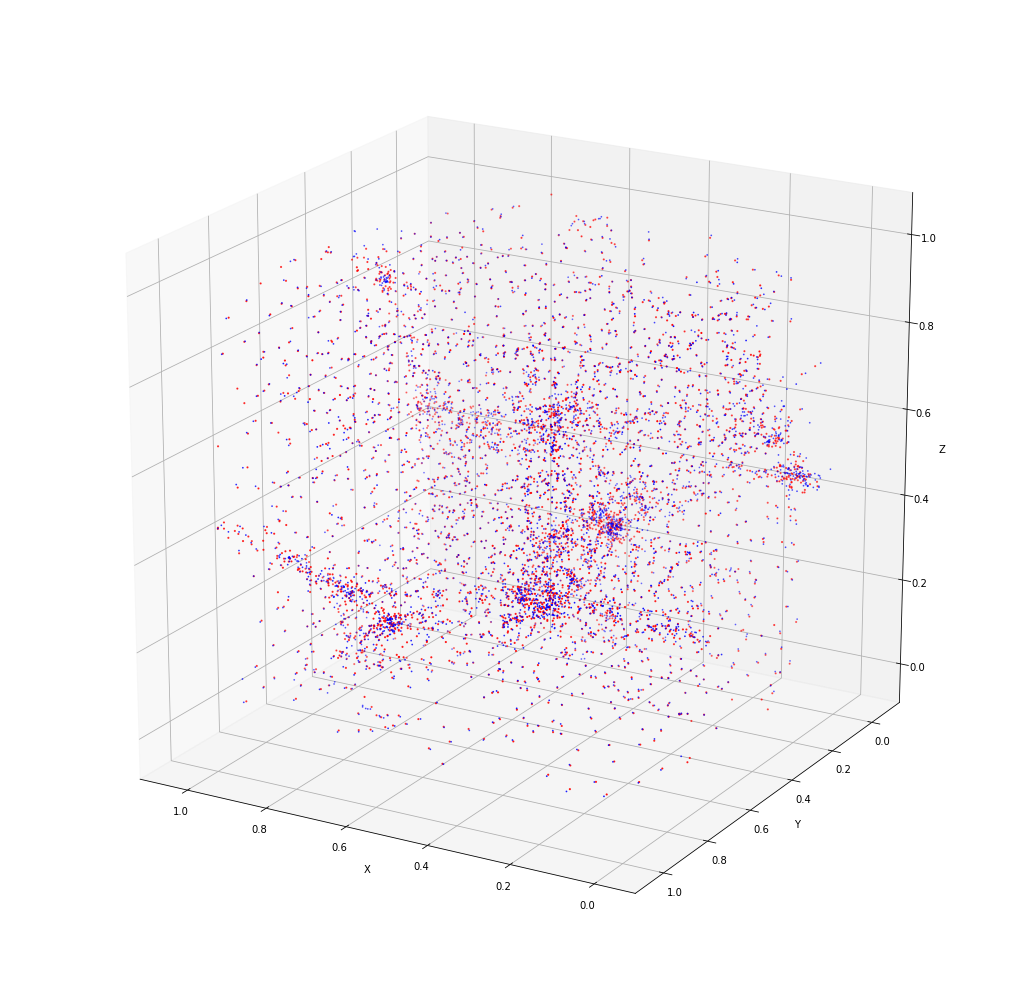

In [11]:
'''
plot point cloud
'''
j = 6
fsize = (18,18)
particle_size = (.6, 1.3)
truth_color = 'blue'
pred_color = 'red'
colors = (truth_color, pred_color)

plt.close('all')
fig = plot_3D_pointcloud(xt, xh, j, colors=colors, pt_size=particle_size, fsize=fsize)
plt.gca().view_init(20, 120)
display.display(plt.gcf())
display.clear_output(wait=True)
time.sleep(0.0001)
rotate = False
if rotate:
    for angle in range(0,360,40):
        fig.view_init(30, angle)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)
#fig.savefig('./Plots/' + model_name, dpi=2400,bbox_inches='tight') # warning, this makes a huge image

In [7]:
'''
Save current
'''
print('save {} loss history'.format(model_name))
np.save(model_dir + 'loss_history_' + model_name, loss_history)

save gops_dataset_testing_novar_ loss history


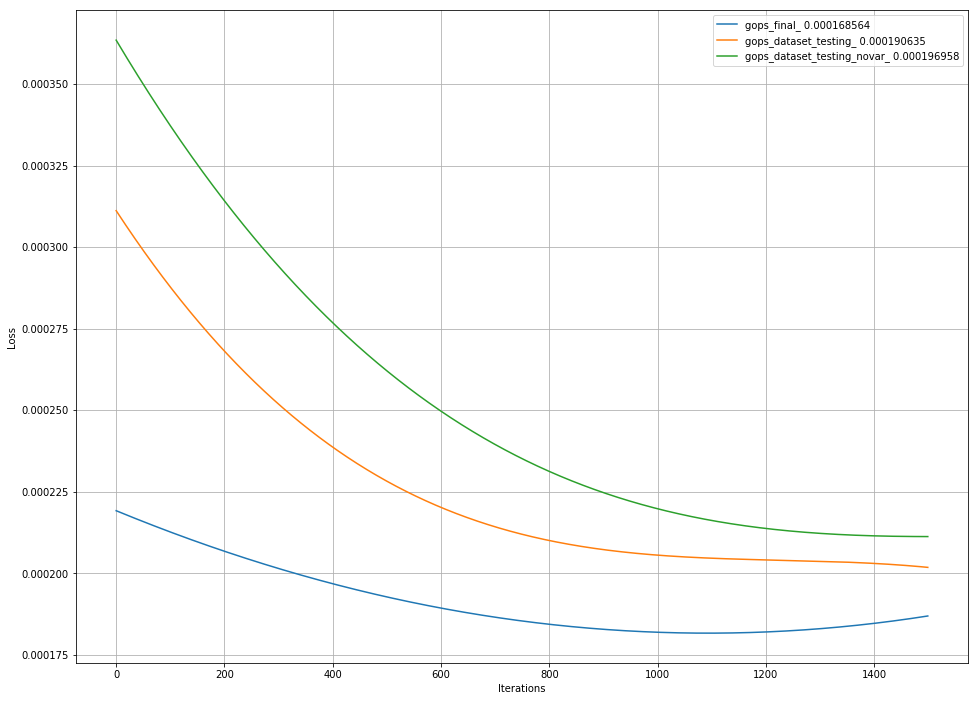

In [8]:
'''
Compare loss curves
'''
"""
loss_labels = ['setmodel_16_8_1000_01_',
               #'graphmodel_14_16_8_1000_01_',
               'velmodel_16_8_1000_01_',
               #'graphmodel_14_16_8_2000_01_',
               #'graphmodel2_14_16_8_2000_01_',
               #'graphmodel2_14_16_8_1000_01_',
               'testing_',
              ]
loss_labels = ['normal_set_model_0600_2000_',
               'normal_graph_model_0600_2000_',
               'comb_set_model_0600_2000_',
               'comb_graph_model_0600_2000_'
              ]

loss_labels = [#'setmodel_1.2-0.0_16_8_1000_01_',
               #'velmodel_1.2-0.0_16_8_1000_01_',
               'velmodel_1.2-0.0_16_8_2000_01_',
               'graphmodel_1.2-0.0_16_8_2000_01_',
              ]
loss_labels32 = [#'setmodel_32_8_1000_01_',
                 'comb_graph_model32_0600_2000_',
                 'combs_model32_0600_2000_',#graph
                 'graph_model32_0600_2000_',
                ]"""
labels_gops = [#'gopsrefac_nocopy_12345_',
               #'gops_refac_copy_12345_',
               #'gops_refac_modelcalltocpu_12345_',
               #'gops_refac_modelcalltocpu_12345_CONFIRM_',
               #'gops_refac_modelcalltocpu_12345_CONFIRM2_',
               'gops_final_',
               'gops_dataset_testing_',
               'gops_dataset_testing_novar_',
               #'gops_dataset_testing98765_',
              ]
loss_labels = labels_gops
loss_files = [np.load(model_dir + 'loss_history_' + fname + '.npy') for fname in loss_labels]
loss_curves = {label:loss for label,loss in zip(loss_labels, loss_files)}
iterations = np.arange(loss_files[0].shape[0])
plt.close('all')
plt.clf()
#plt.yscale('log')
plt.figure(figsize=(16,12))
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
#plt.ylim([0,.001])
pstart = 500
for label, loss in loss_curves.items():
    if label[:5] == 'comb_':
        loss = loss[:,1]
    linsp = np.arange(pstart,loss.shape[0])
    poly = np.poly1d(np.polyfit(linsp, loss[pstart:], 3))
    plt.plot(poly(linsp), label=(label + ' ' + str(np.median(loss[-50:]))))
    #plt.plot(loss[pstart:], label=(label + ' ' + str(np.median(loss[-50:]))))

plt.legend()
plt.show()

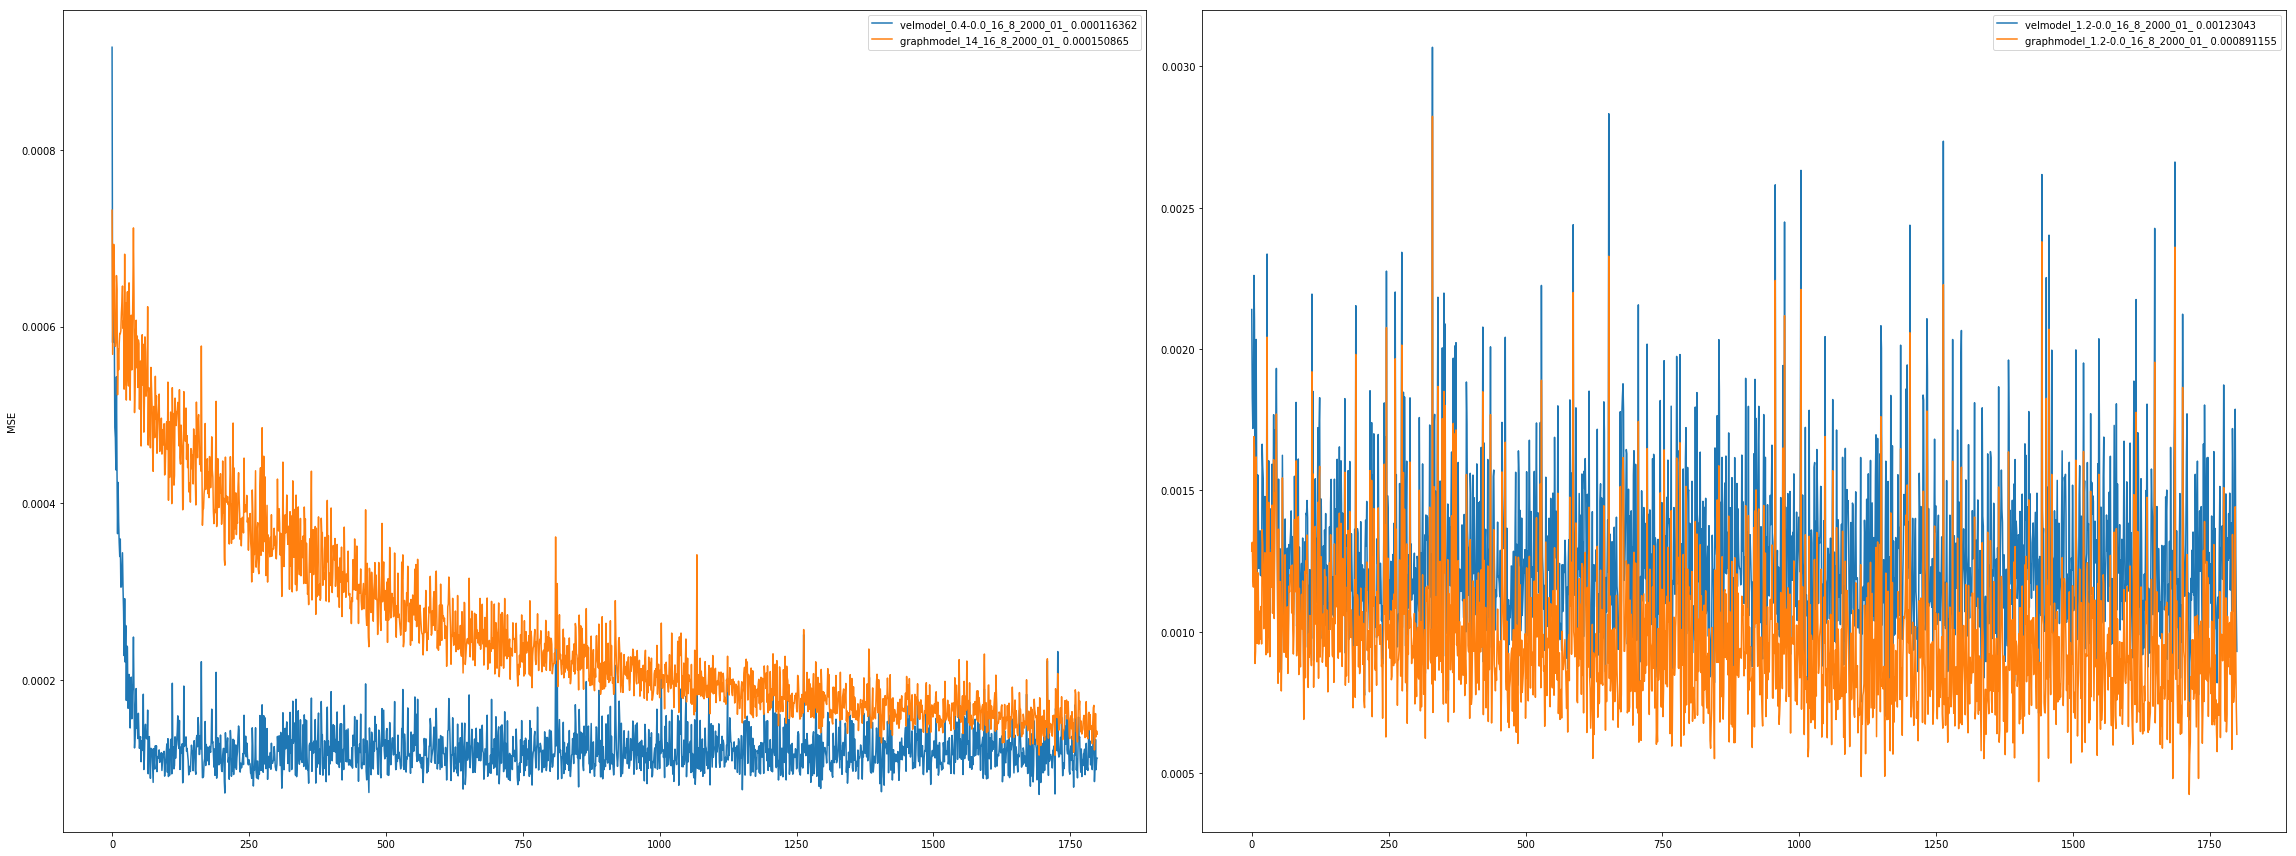

In [9]:
'''
Compare loss curves
'''
loss_labels = [#'velmodel_16_8_1000_01_',
               #'setmodel_16_8_1000_01_',
               'velmodel_0.4-0.0_16_8_2000_01_',
               'graphmodel_14_16_8_2000_01_',             
              ]
loss_labels2 = [#'velmodel_1.2-0.0_16_8_1000_01_',
                #'setmodel_1.2-0.0_16_8_1000_01_',               
               'velmodel_1.2-0.0_16_8_2000_01_',
               'graphmodel_1.2-0.0_16_8_2000_01_',
                #'velmodel_4.0-0.2_16_8_2000_01_',
                #'graphmodel_4.0-0.2_16_8_2000_01_',
              ]

loss_labels32 = ['setmodel_32_8_1000_01_',    
                ]

loss_files1 = [np.load(model_dir + 'loss_history_' + fname + '.npy') for fname in loss_labels]
loss_files2 = [np.load(model_dir + 'loss_history_' + fname + '.npy') for fname in loss_labels2]
loss_curves1 = {label:loss for label,loss in zip(loss_labels, loss_files1)}
loss_curves2 = {label:loss for label,loss in zip(loss_labels2, loss_files2)}
#iterations = np.arange(loss_files[0].shape[0])
plt.close('all')
comp_fig = plt.figure(figsize=(32, 12))
ax1 = comp_fig.add_subplot(121)
ax1.set_ylabel('MSE')
ax2 = comp_fig.add_subplot(122)
#plt.ylim([0,.001])
pstart = 200
for label, loss in loss_curves1.items():
    ax1.plot(loss[pstart:], label=(label + ' ' + str(np.mean(loss[-50:]))))
    ax1.legend()

for label, loss in loss_curves2.items():
    ax2.plot(loss[pstart:], label=(label + ' ' + str(np.mean(loss[-50:]))))
    ax2.legend()

plt.tight_layout()
#plt.savefig('Vel_Graph_04-00_40-02_trCurves', bbox_inches='tight')
plt.savefig('Vel_Set_04-00_12-00_trCurves', bbox_inches='tight')
plt.show()

In [ ]:
import mayavi
from mayavi import mlab
import numpy as np

"""
Note: this script is in it's own directory because it uses a different
      virtualenv to manage mayavi/vtk dependencies 
"""

def volumize_ptc(data_in, opacity=.5, labels=None, color=(1,0,0),frame=True, 
                 row=0, col=0, show=True, figure=None, proj=(False,True,True),
                 shadow=(False,True,True), mode='point', scale_factor=.015,
                 filename=None,):
    if figure is None:
        figure = mlab.figure(1, size=(400, 400), bgcolor=(0, 0, 0), fgcolor=(1, 0, 0))

    data = data_in.copy()
    data -= np.min(data, keepdims=True)
    data /= np.max(data, keepdims=True)
    data[:,0] += np.float(col)
    data[:,1] += np.float(row)
    xproj, yproj, zproj = proj
    xshadow, yshadow, zshadow = shadow
    if labels is None:
        pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
        #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
        #pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_mode='scalar', scale_factor=scale_factor)
        #pts = mlab.points3d(data[:,0], data[:,1], data[:,2], color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
    else:
        for l in np.unique(labels):
            color = tuple(list(np.random.rand(3)))
            ind = (labels == l).nonzero()[0]
            mlab.pipeline.volume(mlab.points3d(data[ind,0], data[ind,1], data[ind,2], 
                                               mode=mode, color=color, opacity=opacity))
    if frame:
        r_points = np.array([0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0]) + row + .0
        c_points = np.array([0,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1]) + col +.0
        d_points = np.array([0,0,0,0,1,1,1,0,0,1,1,1,0,0,1,1,0,0]) +.0
        mlab.plot3d(c_points, r_points, d_points, representation='surface',
                    tube_radius=.003, line_width=1, figure=figure, opacity=.7, color=(1,1,1))

    #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
    mlab.view(azimuth=20, elevation=70, distance=3, focalpoint=None, roll=None, reset_roll=True, figure=figure)    
    if filename is not None:
        mlab.savefig(filename, size=(500,500), figure=figure, magnification='auto') 
        if not show: mlab.clf()
    if show: mlab.show()



def volumize_arrow(datain,# n x 3
                   arrow, #nx3
                 opacity=.5, labels=None,
                 color=(1,0,0),
                 frame=True, row=0, col=0,
                 show=True,
                 figure=None,
                 proj=(False,True,True),
                 shadow=(False,True,True),
                 mode='point',
                 scale_factor=.001,
                 filename=None,
                 normalize=False,
):
    if figure is None:
        figure = mlab.figure(1, size=(400, 400), bgcolor=(0, 0, 0), fgcolor=(1, 0, 0))

    data = datain.copy()
    if normalize:
        data -= np.min(data, keepdims=True)
        data /= np.max(data, keepdims=True)
    data[:,0] += np.float(col)
    data[:,1] += np.float(row)
    xproj,yproj,zproj = proj
    xshadow,yshadow,zshadow=shadow
    if labels is None:
        #pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
        #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
        pts = mlab.quiver3d(data[:,0], data[:,1], data[:,2], arrow[:,0], arrow[:,1], arrow[:,2], color=color, opacity=opacity, figure=figure, mode=mode)
    else:
        for l in np.unique(labels):
            color = tuple(list(np.random.rand(3)))
            ind = (labels == l).nonzero()[0]
            mlab.pipeline.volume(mlab.points3d(data[ind,0], data[ind,1], data[ind,2], mode=mode, color=color, opacity=opacity))
    if frame:
        r_points = np.array([0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0]) + row + .0
        c_points = np.array([0,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1]) + col +.0
        d_points = np.array([0,0,0,0,1,1,1,0,0,1,1,1,0,0,1,1,0,0]) +.0
        mlab.plot3d(c_points, r_points, d_points, representation='surface',tube_radius=.003, line_width=1, figure=figure, opacity=.7, color=(1,1,1))


    #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
    mlab.view(azimuth=20, elevation=70, distance=3, focalpoint=None, roll=None, reset_roll=True, figure=figure)    
    if filename is not None:
        mlab.savefig(filename, size=(500,500), figure=figure, magnification='auto') 
        if not show:
            mlab.clf()
    if show:
        mlab.show()

j = 3 # sample

x_input = _x_in
x_truth = xt
x_pred  = xh

xtmp = x_input[j,:,:3]
bound = 0.095
lower, upper = bound, 1-bound
mask1 = np.logical_and(xtmp[:,0] < upper, xtmp[:,0] > lower) 
mask2 = np.logical_and(xtmp[:,1] < upper, xtmp[:,1] > lower) 
mask3 = np.logical_and(xtmp[:,2] < upper, xtmp[:,2] > lower) 
mask = mask1 * mask2 * mask3
mask_nz = np.nonzero(mask)[0]

fig = mlab.figure(1, size=(400, 400), bgcolor=(1, 1, 1), fgcolor=(1, 0, 0))
red   = (1,0,0)
green = (0,1,0)
blue  = (0,0,1)
arrow_mode = 'arrow'
sfactor = .005

displacement = np.mean((x_truth[:,mask_nz,:3] - x_input[:,mask_nz,:3]),axis=(1,2))
greatest = np.argmax(np.abs(displacement))
least = np.argmin(np.abs(displacement))
#print('displacement: {} at {}'.format(displacement[j], j))

arrow_true  = (x_input[j,mask_nz,:3], x_truth[j,mask_nz,:3] - x_input[j,mask_nz,:3])
arrow_input = (x_input[j,mask_nz,:3], x_input[j,mask_nz,3:])
arrow_pred  = (x_input[j,mask_nz,:3], x_pred[j, mask_nz,:3] - x_input[j,mask_nz,:3])
volumize_arrow(*arrow_true,  figure=fig, color=red,   opacity=.3, show=False, mode=arrow_mode)
volumize_arrow(*arrow_input, figure=fig, color=green, opacity=.3, show=False, mode=arrow_mode)
volumize_arrow(*arrow_pred,  figure=fig, color=blue,  opacity=.3, show=True,  mode=arrow_mode)
#volumize_ptc(x_truth[j,:,:3], show=False,figure=fig, opacity=.9, color=red,  mode='point', scale_factor=sfactor)
#volumize_ptc(x_input[j,:,:3], show=False,figure=fig, opacity=.9, color=green,mode='point', scale_factor=sfactor)
#volumize_ptc( x_pred[j,:,:3], show=True, figure=fig, opacity=.9, color=blue, mode='point', scale_factor=sfactor)